## Auto reload

In [1]:
%load_ext autoreload
%autoreload 2

## LIB

In [2]:
%reload_ext autoreload

# Basic lib
import pandas as pd
import numpy as np
import os
import sys

# config
import yaml

# Custom lib
from src.loader import Loader
from src.loan_preprocessor import Loan_Preprocessor
from src.log_preprocessor import Log_Preprocessor
from src.user_preprocessor import User_Preprocessor
from src.cofix_preprocessor import Cofix_Preprocessor
from src.matcher import Matcher

# ignore warnings
pd.set_option('mode.chained_assignment',  None)

c:\Users\JeongSeongYun\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Load Config

In [3]:
with open("config.yaml", 'r') as config_file:
    config_dict = yaml.load(config_file, Loader=yaml.FullLoader)

FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

## Load Data

In [ ]:
loader_config = config_dict.get('Loader')

In [80]:
loader_config = config_dict.get('Loader')
loader = Loader(loader_config)
loan_df = loader.run('loan_result.csv')
log_df = loader.run('log_data.csv')
user_df = loader.run('user_spec.csv')
cofix_df = loader.run('cofix.csv')

## Preprocess

In [81]:
prep_config = config_dict.get('Preprocessor')

# Loan preprocess
loan_preprocessor = Loan_Preprocessor(loan_df, prep_config)
prep_loan_df = loan_preprocessor.run(
    save_file_name='prep_loan.fth',
    save_mode=True
    )

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
✅ prep dataset saved at (data\prep\prep_loan.fth)


In [82]:
# Log preprocess
log_preprocessor = Log_Preprocessor(log_df, prep_config)
prep_log_df = log_preprocessor.run(
    save_file_name='prep_log.fth',
    save_mode=True
)

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
카테고리화 시키는 중...
시간축을 기준으로 정렬 중...
✅ prep dataset saved at (data\prep\prep_log.fth)


In [83]:
# User preprocess
user_preprocessor = User_Preprocessor(user_df, prep_config)
prep_user_df = user_preprocessor.run(
    save_file_name='prep_user.fth',
    save_mode=True
)

datetime으로 바꾸는 중...
파생변수 생성 중...
카테고리화 시키는 중...
원핫인코딩 중...
순서형인코딩 중...
✅ prep dataset saved at (data\prep\prep_user.fth)


In [84]:
# cofix preprocess
cofix_preprocessor = Cofix_Preprocessor(cofix_df, prep_config)
prep_cofix_df = cofix_preprocessor.run(
    save_file_name='prep_cofix.fth',
    save_mode=True
)

대상기간 열 나누는 중...
datetime으로 바꾸는 중...
시간축을 기준으로 정렬 중...
COFIX 금리 열 이름 변경 중...
✅ prep dataset saved at (data\prep\prep_cofix.fth)


## Matcher

In [91]:
matcher_config = config_dict.get('Matcher')

In [92]:
matcher = Matcher(prep_user_df, prep_loan_df, prep_log_df, prep_cofix_df, matcher_config)

In [93]:
train_valid, test = matcher.run(save_mode=True)

Loan과 Cofix 매칭중...
Loan_Cofix와 User 매칭중...
Train(Valid)과 Test로 나누는 중...
✅ matched dataset saved at (data\match\ml_train_valid.fth)
✅ matched dataset saved at (data\match\ml_test.fth)


In [106]:
matched_total = pd.concat(train_valid, test)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

## Modeling

In [88]:
# base line
# model_name : RF, XGB, LGBM, 

## 모델 서치 ##
# from src.models import XGB
# random_state = 42
# xgb = XGB(train_X, train_Y, val_X, val_Y, test_X, test_Y, random_state)
# best_model = xgb.grid_search()

## test 결과 확인 및 모델 해석 ##
# xgb.test_score(best_model)
# xgb.confusion_matrix(best_model)
# xgb.feature_importance(best_model)
# xgb.shap(best_model)


In [5]:
from src.models.rf_model import RF

In [1]:
from src.models.lgbm_model import LGBM

/Users/hanjun/opt/anaconda3/envs/bigcon/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.models.xgb_model import XGB

In [3]:
from src.models.catboost import CB

# Clustering

In [ ]:
'''
Example
1. 그냥 전처리 후의 시각화
clus = ClusteringPreprocessor(df)
clus.run()

2. Extracction 이후의 시각화
clus = ClusteringPreprocessor(df, extraction=True)
clus.run()
'''

전처리 시작...
결측치 제거 전 :  3025600
결측치 제거 후 :  0
Scaling 완료
총 4개의 DataFrame이 나왔습니다. shape : (118255, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118255 entries, 0 to 118254
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   gender_0.0                               118255 non-null  float64
 1   gender_1.0                               118255 non-null  float64
 2   income_type_EARNEDINCOME                 118255 non-null  float64
 3   income_type_EARNEDINCOME2                118255 non-null  float64
 4   income_type_FREELANCER                   118255 non-null  float64
 5   income_type_PRACTITIONER                 118255 non-null  float64
 6   income_type_PRIVATEBUSINESS              118255 non-null  float64
 7   employment_type_계약직                      118255 non-null  float64
 8   employment_type_기타                       118255 non-null  float64
 9   emp

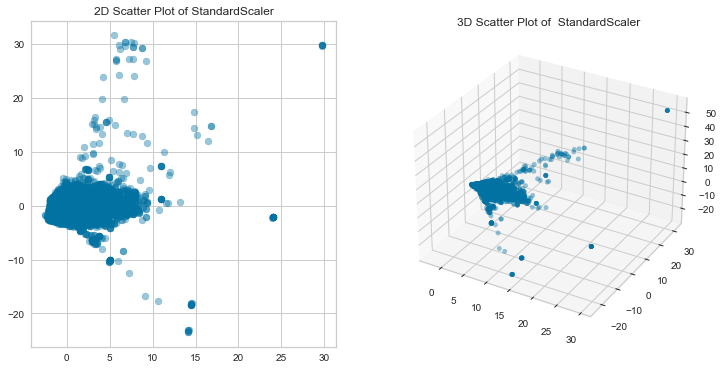

현재 Scaler :  MinMaxScaler


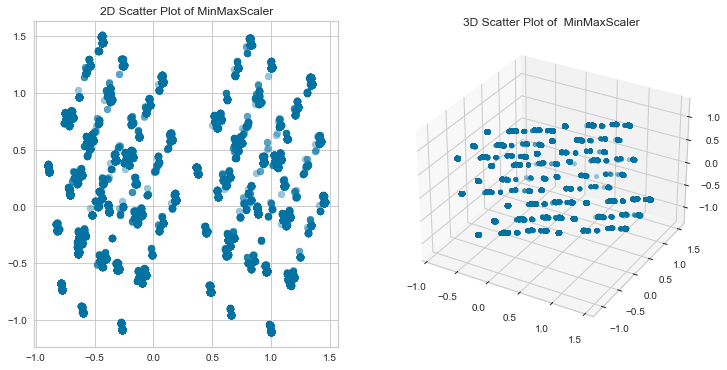

현재 Scaler :  RobustScaler


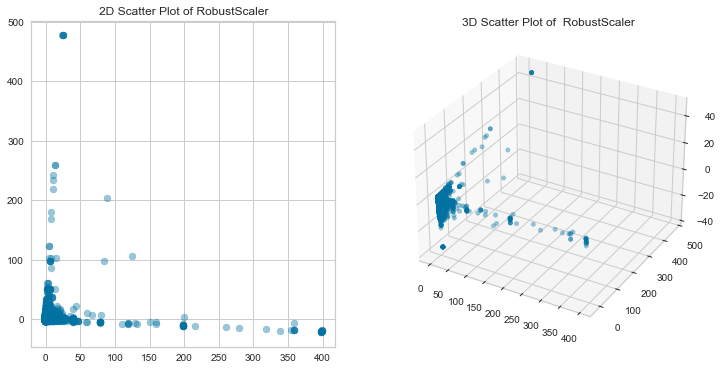

현재 Scaler :  PowerTransformer


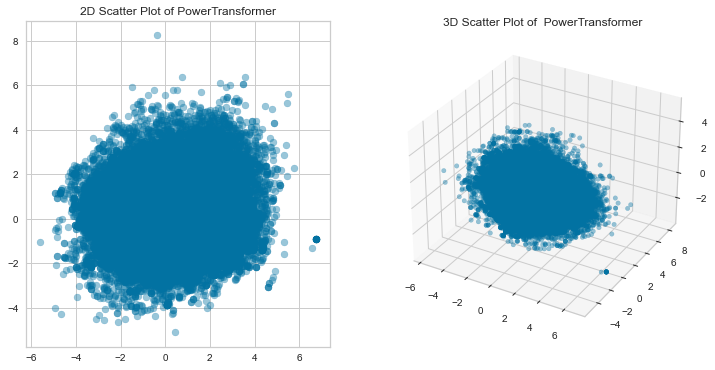

Done


In [21]:
from src.clustering import Clustering
from src.clustering_preprocessor import ClusteringPreprocessor

df = pd.read_csv('./data/user_spec.csv')

clus = ClusteringPreprocessor(df, extraction=True)
extact_test = clus.run()
extact_test


## Inference

## Evaluation